In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
print(tf.__version__)
print(keras.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.10.0
2.10.0
Num GPUs Available:  1


# Task 1

## 2.
1. Fashion MNIST 
- Loading data
- creating train, validation and test set 
- create class names


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                   "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

#num_classes = 10
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_valid = keras.utils.to_categorical(y_valid, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

- create model 

In [ ]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[28, 28], opt = "SGD"): 
    model = keras.models.Sequential() 
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = eval("".join(["keras.optimizers.",opt, "(lr=learning_rate)"]))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics = ['accuracy'])
    return model

In [ ]:
keras_reg = keras.wrappers.scikit_learn.KerasClassifier(build_model)


In [ ]:
keras_reg.fit(X_train, y_train, epochs=100,
            validation_data=(X_valid, y_valid),
            callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=0.001)])
mse_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_new)

In [ ]:
param_distribs = {
        "n_hidden": [0, 1, 2, 3],
        "n_neurons": np.arange(1, 100),
        "learning_rate": reciprocal(3e-4, 3e-2),
        "opt": ["SGD","Adam"],
}

In [ ]:
# this runs for 43 minutes with a 24 GB GPU 
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=300,
                batch_size=50,
                validation_data=(X_valid, y_valid),
                callbacks=[keras.callbacks.EarlyStopping(patience=3, min_delta=0.001)])

In [ ]:
print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)
# 

In [ ]:
model = rnd_search_cv.best_estimator_.model
model.evaluate(X_test, y_test)
model.save("MLP_brute.h5")

Optimizing search with KerasTuner:
- l1&l2 regularization slowed down the search process by a lot

In [40]:
hp = keras_tuner.HyperParameters()
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 6)):
        model.add(
            layers.Dense(
                # Tune number of neurons separately.
                units=hp.Int(f"units_{i}", min_value=30, max_value=515, step=31),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(10, activation="softmax"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

build_model(keras_tuner.HyperParameters())

choosing tuner: https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f

In [41]:
Tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    num_initial_points=2,
    seed=90,
    directory="Task1",
    project_name="MLP",
    #overwrite=True,
)


INFO:tensorflow:Reloading Oracle from existing project Task1\MLP\oracle.json


In [37]:
Tuner.search_space_summary()


Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 515, 'step': 31, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [42]:
Tuner.search(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))


Trial 9 Complete [00h 03m 01s]
val_accuracy: 0.9064000248908997

Best val_accuracy So Far: 0.9064000248908997
Total elapsed time: 00h 25m 43s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
6                 |6                 |num_layers
495               |495               |units_0
relu              |relu              |activation
True              |True              |dropout
0.0001            |0.0001            |lr
30                |92                |units_1
185               |495               |units_2
402               |123               |units_3
464               |495               |units_4
30                |30                |units_5

Epoch 1/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7554 - accuracy: 0.7449 - val_loss: 0.4224 - val_accuracy: 0.8496
Epoch 2/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4746 - accuracy: 0.8420 - val_loss: 0.3953 - val_accuracy: 0.8614
Epoch 3/30
1719/1719 [=====

KeyboardInterrupt: 

In [29]:

# Get the top 3 models.
models_mlp = Tuner.get_best_models(num_models=3)
best_model_mlp = models_mlp[0]
# Build model
best_model_mlp.build(input_shape=(None, 28, 28))
best_model_mlp.summary()
Tuner.results_summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 495)               388575    
                                                                 
 dense_1 (Dense)             (None, 30)                14880     
                                                                 
 dense_2 (Dense)             (None, 402)               12462     
                                                                 
 dense_3 (Dense)             (None, 30)                12090     
                                                                 
 dense_4 (Dense)             (None, 123)               3813      
                                                                 
 dense_5 (Dense)             (None, 371)               4

In [30]:
best_model_mlp.evaluate(X_test, y_test)
best_model_mlp.save("best_mlp.h5")

313/313 [==============================] - 1s 3ms/step - loss: 54.1202 - accuracy: 0.8650


Epoch 1/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1344 - accuracy: 0.9495 - val_loss: 0.3765 - val_accuracy: 0.8988
Epoch 2/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1282 - accuracy: 0.9515 - val_loss: 0.3378 - val_accuracy: 0.9018
Epoch 3/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1262 - accuracy: 0.9532 - val_loss: 0.3674 - val_accuracy: 0.8936
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1240 - accuracy: 0.9526 - val_loss: 0.3921 - val_accuracy: 0.9054
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1211 - accuracy: 0.9550 - val_loss: 0.3942 - val_accuracy: 0.8972
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1170 - accuracy: 0.9551 - val_loss: 0.4268 - val_accuracy: 0.9018
Epoch 7/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1185 - accuracy: 0.9554 - val_loss: 0.3722 - val_accuracy:

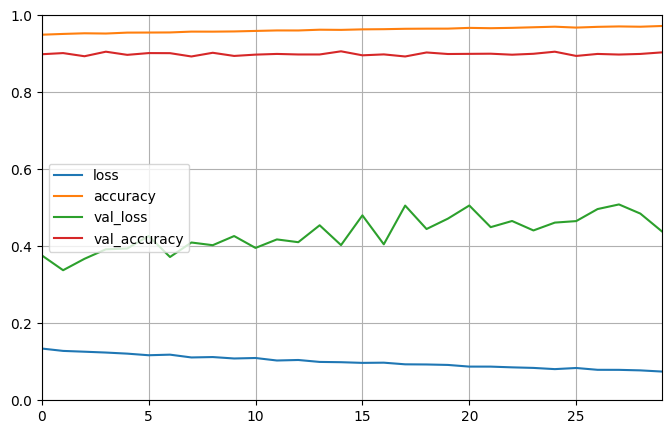

In [34]:
history = best_model_mlp.fit(X_train, y_train, epochs=30, 
                        validation_data=(X_valid, y_valid))

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # set the vertical range to [0-1]
plt.gca().set_xlim(0,29)
plt.show()

## CNN

In [3]:
hp = keras_tuner.HyperParameters()
def build_model_cnn(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        # adding kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=[28,28,1],
        padding='same',)
    )
    model.add(
    layers.MaxPooling2D(pool_size = 2
    ),
    )
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Conv2D(
                #adding filter 
                filters=hp.Int(f'conv_{i}_filter', min_value=32, max_value=128, step=16),
                # adding kernel size
                kernel_size=hp.Choice(f'conv_{i}_kernel', values = [3,5]),
                #activation function
                activation='relu',
                padding='same'),
        )
        model.add(
            layers.MaxPooling2D(
                pool_size = hp.Choice(f'pool_{i}_size', values = [2,4,6])
            ),
            )
            
    model.add(layers.Flatten())        

    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=60, max_value=515, step=20),
                activation=hp.Choice("activation", ["relu", "tanh"]),),
        )
        
        if hp.Boolean("dropout"):
            model.add(layers.Dropout(rate=hp.Choice(f'rate_{i}', values = [0.25,0.5,0.75])))
    
    model.add(layers.Dense(10, activation="softmax"))

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

build_model_cnn(keras_tuner.HyperParameters())

In [4]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model_cnn,
    objective="val_accuracy",
    max_trials=20,
    num_initial_points=2,
    seed=90,
    directory="Task1",
    project_name="CNN",
    #overwrite=True,
    #executions_per_trial,
)

INFO:tensorflow:Reloading Oracle from existing project Task1\CNN\oracle.json
INFO:tensorflow:Reloading Tuner from Task1\CNN\tuner0.json


In [92]:
tuner.search_space_summary()

Search space summary
Default search space size: 10
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
conv_0_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_0_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
pool_0_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 4, 6], 'ordered': True}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 515, 'step': 31, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': 

In [112]:
tuner.search(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100)


Trial 20 Complete [00h 01m 21s]
val_accuracy: 0.9351999759674072

Best val_accuracy So Far: 0.9358000159263611
Total elapsed time: 00h 26m 09s
INFO:tensorflow:Oracle triggered exit


In [5]:
# Get the top 3 models.
models_cnn = tuner.get_best_models(num_models=3)
best_model_cnn = models_cnn[0]
# Build model
best_model_cnn.build(input_shape=(None, 28, 28))
best_model_cnn.summary()
#tuner.results_summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 112)       1120      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 112)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       129152    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 500)               3

In [6]:
best_model_cnn.evaluate(X_test, y_test)
best_model_cnn.save("best_cnn.h5")

313/313 [==============================] - 4s 2ms/step - loss: 56.3299 - accuracy: 0.8834


## CIFAR10

In [119]:
cifar10 = keras.datasets.cifar10
(x_train_full_cif, y_train_full_cif), (x_test_full_cif, y_test_full_cif) = cifar10.load_data()
X_valid, X_train = x_train_full_cif[:5000] / 255.0, x_train_full_cif[5000:] / 255.0
y_valid, y_train = y_train_full_cif[:5000], y_train_full_cif[5000:]


170498071/170498071 [==============================] - 20s 0us/step


In [120]:
model_mlp_cifar = keras.models.load_model("best_mlp.h5")
model_cnn_cifar = keras.models.load_model("best_cnn.h5")

In [121]:
history = model_cnn_cifar.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] plt.show()
model_cnn_cifar.evaluate(x_test_full_cif, y_test_full_cif)

Epoch 1/30


ValueError: in user code:

    File "c:\Users\felix.wente\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\felix.wente\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\felix.wente\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\felix.wente\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\felix.wente\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\felix.wente\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 28, 28, 1), found shape=(None, 32, 32, 3)
